# Exercises

## Exercise 1
---

You can find below the code that was used to generate the activity of place cells on a linear track.
Use the code and the decoding procedure you lerned about in the lesson to explore how different features of the data impact our ability to decode position.
In particular:

A - Try to use different fractions of our data samples. How does the median error change when the the number of available sample gets larger? You do not need to re-generate any data, just randomly sub-sample the data to different fractions.

B - How many place cells do we need to reliably decode position? Try to re-do the decoding using only 10 cell, then 20, and so on. How does the median error change? Does it reach an asymptote? (Also in this case, you do not need to re-generate the data, you can just select a random subset of cells each time)

C - Generate new data using the code below, changing the firing rate noise (changing the value of the variable `noise firing_rate`). How does this noise impact the decoding? 

### Code for data generation

In [6]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import poisson
from tqdm import tqdm
import seaborn as sns

%matplotlib inline 
plt.rcParams['figure.figsize'] = [10, 5]
from ipywidgets import interact
import ipywidgets as widgets


track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

In [7]:
bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

In [8]:
# GENERATE TRAJECTORY

n_runs = 10
use_stops = False
av_running_speed = 10 # the average running speed (in cm/s)
fps = 10 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])


for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    if use_stops:
        x = np.concatenate((x, stop1, run1, stop2, run2))
    else:
         x = np.concatenate((x, run1, run2))
t = np.arange(len(x))/fps

In [9]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in range(n_cells):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

In [18]:
import pickle

file_name = 'Exercise1.pickle' # change this name when you save new data

out_data = {}
out_data['x'] = x
out_data['t'] = t
out_data['spikes'] = spikes
out_data['track_length'] = track_length
out_data['fps'] = fps

with open('data/'+file_name,'wb') as f:
    pickle.dump(out_data,f)

In [10]:
# Firing Rate Maps

# poistion at which each spike was emitted
spike_positions = [np.interp(s, t, x) for s in spikes]
space_bins = np.arange(0., track_length, 5.) # binning in bins of 5 cms

# histograms for each cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
spikes_hist = np.asarray(spikes_hist)
occupancy = np.histogram(x, space_bins)[0] /  fps
# firing rate maps
firing_rate_maps = spikes_hist / occupancy 

spikes_count= [np.histogram(s,t)[0] for s in spikes]
spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar (samples x features) shape

Fraction 0.8: 100%|████████████████████████████████████████████████████████████████| 3855/3855 [00:21<00:00, 177.87it/s]


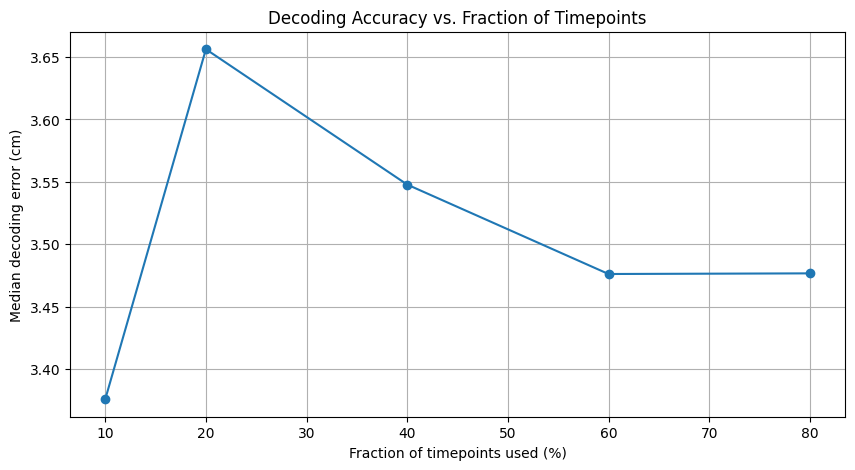

10% of data → median error: 3.38 cm
20% of data → median error: 3.66 cm
40% of data → median error: 3.55 cm
60% of data → median error: 3.48 cm
80% of data → median error: 3.48 cm


In [46]:
# Exercise 1A

fractions = [0.1, 0.2, 0.4, 0.6, 0.8]
errors = []

true_x = x[:-1] # get rid of last timepoint to have same length as binned spikes
decoding_times = t[:-1]

for frac in fractions:
    # Randomly select a subset of time bins
    n_samples = int(len(decoding_times) * frac)
    selected_indices = np.sort(np.random.choice(len(decoding_times), n_samples, replace=False))

    x_decoded = np.zeros_like(true_x)

    for t_bin in tqdm(selected_indices, desc=f"Fraction {frac:.1f}"):
        if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
            posterior = np.empty(firing_rate_maps.shape[-1])
            
            for i in range(len(posterior)):
                posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15))
                
            x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan

    # Compute median error
    mse = np.sqrt((true_x[selected_indices] - x_decoded[selected_indices]) ** 2)
    median_error = np.nanmedian(mse)
    errors.append(median_error)

# Plot results
plt.plot(np.array(fractions) * 100, errors, marker='o')
plt.xlabel('Fraction of timepoints used (%)')
plt.ylabel('Median decoding error (cm)')
plt.title('Decoding Accuracy vs. Fraction of Timepoints')
plt.grid(True)
plt.show()

# Print summary
for f, e in zip(fractions, errors):
    print(f"{int(f*100)}% of data → median error: {e:.2f} cm")


**Report**

After running this code a few times, the overall trend would be that the median error decreases as the proportion of data increases. However, since we are using random sup-sampling here, the trends change every time, as some time bins may have better track coverage than others, so at some times, the samples contain more informative spikes, while at others they dont. To get better resutls, the loop should be repeated around 10 times, taking the average.  

Cells: 100: 100%|██████████████████████████████████████████████████████████████████| 4819/4819 [00:22<00:00, 217.83it/s]


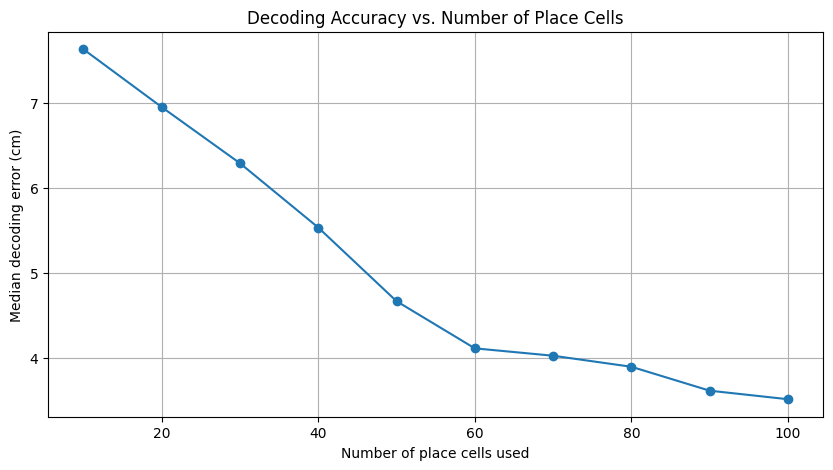

10 cells → median error: 7.63 cm
20 cells → median error: 6.95 cm
30 cells → median error: 6.29 cm
40 cells → median error: 5.53 cm
50 cells → median error: 4.66 cm
60 cells → median error: 4.11 cm
70 cells → median error: 4.02 cm
80 cells → median error: 3.89 cm
90 cells → median error: 3.61 cm
100 cells → median error: 3.51 cm


In [45]:
# Exercise 1B

cell_numbers = list(range(10, n_cells+1, 10))  # e.g., 10, 20, ..., 100
errors = []

true_x = x[:-1]
decoding_times = t[:-1]

for n_cells_subset in cell_numbers:
    # Randomly select a subset of cells
    selected_cells = np.random.choice(n_cells, n_cells_subset, replace=False)
    
    x_decoded = np.zeros_like(true_x)
    
    for t_bin in tqdm(range(len(decoding_times)), desc=f"Cells: {n_cells_subset}"):
        # obtain spikes and firing rate maps only for selected subset of cells
        spikes_sub = spikes_count[t_bin, selected_cells]
        firing_maps_sub = firing_rate_maps[selected_cells, :]
        
        if np.sum(spikes_sub) > 0: 
            posterior = np.empty(firing_maps_sub.shape[-1])
            for i in range(len(posterior)):
                posterior[i] = np.sum(poisson.logpmf(spikes_sub, firing_maps_sub[:, i] / fps) + 1e-15)
            x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan
    
    # median decoding error
    mse = np.sqrt((true_x - x_decoded) ** 2)
    median_error = np.nanmedian(mse)
    errors.append(median_error)

# Plot 
plt.plot(cell_numbers, errors, marker='o')
plt.xlabel('Number of place cells used')
plt.ylabel('Median decoding error (cm)')
plt.title('Decoding Accuracy vs. Number of Place Cells')
plt.grid(True)
plt.show()

# Summary
for n_cells_subset, err in zip(cell_numbers, errors):
    print(f"{n_cells_subset} cells → median error: {err:.2f} cm")

**Report**

As can be seen in the graph, the median error decreases as more place cells are included. This decrease is steeper in the beginning, and then eventually starts to plateau (i.e. it reaches an asymptote), starting around 60 place cells. 

100%|██████████████████████████████████████████████████████████████████████████████| 4854/4854 [00:24<00:00, 195.36it/s]


Median error with 0.1 noise: 3.589743589743591 cm


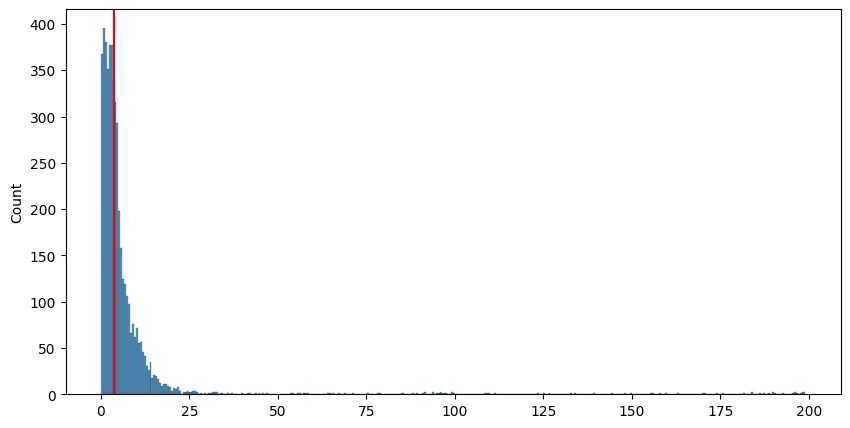

In [53]:
# Exercise 1C

# mse for original data
with open('data/Exercise1.pickle', 'rb') as f:
    data = pickle.load(f)

# decode
true_x = x[:-1] # get rid of last timepoint to have same length as binned spikes
decoding_times = t[:-1]

x_decoded = np.zeros_like(true_x)

for t_bin in tqdm(range(len(decoding_times))):
    if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
        posterior = np.empty(firing_rate_maps.shape[-1])

        for i in range(len(posterior)):
            # Note that we work with log so that we can sum probabilities
            # instead of multiplying them 
            #posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
            posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15))


        x_decoded[t_bin] = space_bins[np.argmax(posterior)]
    else:
        x_decoded[t_bin] = np.nan   
        
# error distribution
mse = np.sqrt((true_x-x_decoded)**2)
sns.histplot(mse)
plt.axvline(x = np.nanmedian(mse),c='r')
print(f'Median error with 0.1 noise: {np.nanmedian(mse)} cm')

100%|██████████████████████████████████████████████████████████████████████████████| 4854/4854 [00:25<00:00, 186.69it/s]


Median error with 0.5 noise: 3.8022479113243435 cm


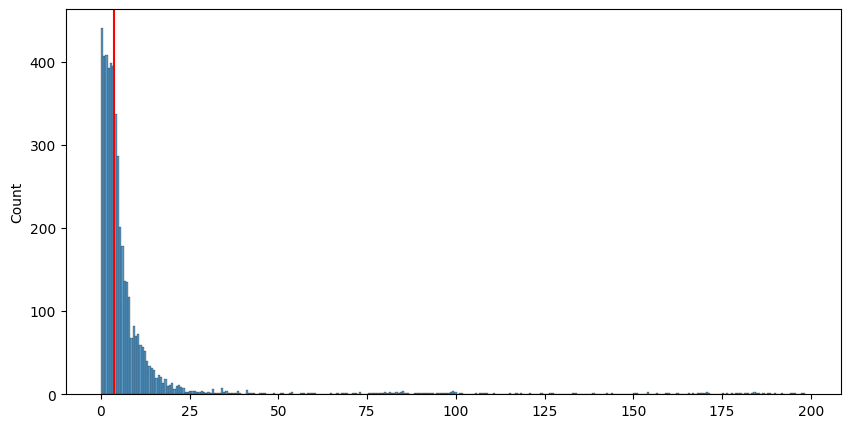

In [55]:
# generate new data
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 1. # changed noise here
spikes = []

for i in range(n_cells):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)
    

file_name = 'Exercise1c.pickle' # change this name when you save new data

out_data = {}
out_data['x'] = x
out_data['t'] = t
out_data['spikes'] = spikes
out_data['track_length'] = track_length
out_data['fps'] = fps

with open('data/'+file_name,'wb') as f:
    pickle.dump(out_data,f)
    

# Firing Rate Maps

# poistion at which each spike was emitted
spike_positions = [np.interp(s, t, x) for s in spikes]
space_bins = np.arange(0., track_length, 5.) # binning in bins of 5 cms

# histograms for each cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
spikes_hist = np.asarray(spikes_hist)
occupancy = np.histogram(x, space_bins)[0] /  fps
# firing rate maps
firing_rate_maps = spikes_hist / occupancy 

spikes_count= [np.histogram(s,t)[0] for s in spikes]
spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar (samples x features) shape

# code decoding
true_x = x[:-1] # get rid of last timepoint to have same length as binned spikes
decoding_times = t[:-1]

x_decoded = np.zeros_like(true_x)

for t_bin in tqdm(range(len(decoding_times))):
    if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
        posterior = np.empty(firing_rate_maps.shape[-1])

        for i in range(len(posterior)):
            # Note that we work with log so that we can sum probabilities
            # instead of multiplying them 
            #posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
            posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15))


        x_decoded[t_bin] = space_bins[np.argmax(posterior)]
    else:
        x_decoded[t_bin] = np.nan   

# error distribution
mse = np.sqrt((true_x-x_decoded)**2)
sns.histplot(mse)
plt.axvline(x = np.nanmedian(mse),c='r')
print(f'Median error with 0.5 noise: {np.nanmedian(mse)} cm')

**Report**

When changing the noise to 1 (compared to 0.1 in the original data), the decoding becomes less acurate, as indicated by a larger median error. 

## Exercise 2
---
In the loop implementation of the decoder, we used `poisson.logpmf(k,mu)` to calculate the log probability of observing $k$ spikes given an average firing rate of $\mu$. 
This is mathematically equivalent to `np.log(poisson.pmf(k,mu))`, in which we calculate the probability, and then take the log.


Re-run the decoding substituting this expression:

```
posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
```

To the line we are using to calculate the posterior.
Do you see any difference in the results? What do you think this is due to?




100%|██████████████████████████████████████████████████████████████████████████████| 4854/4854 [00:26<00:00, 182.06it/s]


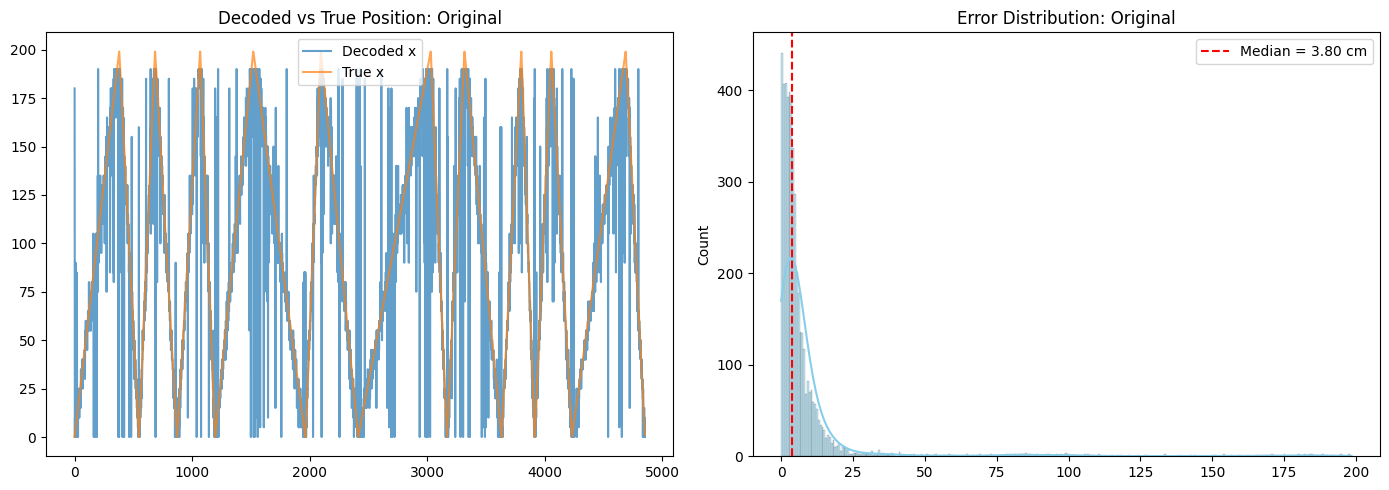

100%|██████████████████████████████████████████████████████████████████████████████| 4854/4854 [00:34<00:00, 142.21it/s]


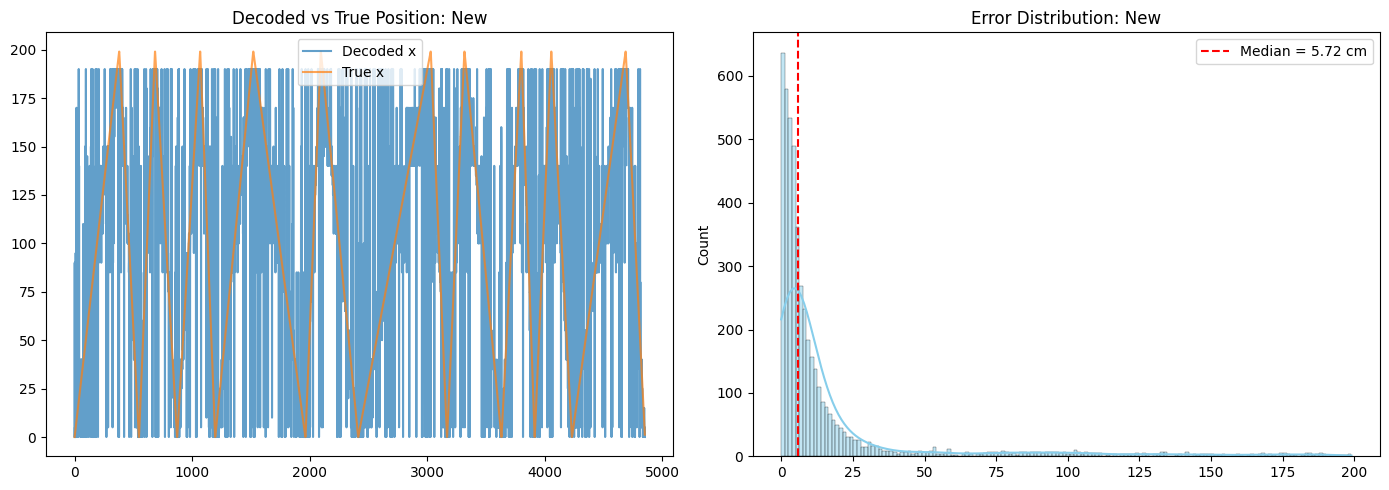

In [59]:
# Exercise 2

# mse for original data
with open('data/Exercise1.pickle', 'rb') as f:
    data = pickle.load(f)

# Firing Rate Maps

# poistion at which each spike was emitted
spike_positions = [np.interp(s, t, x) for s in spikes]
space_bins = np.arange(0., track_length, 5.) # binning in bins of 5 cms

# histograms for each cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
spikes_hist = np.asarray(spikes_hist)
occupancy = np.histogram(x, space_bins)[0] /  fps
# firing rate maps
firing_rate_maps = spikes_hist / occupancy 

spikes_count= [np.histogram(s,t)[0] for s in spikes]
spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar (samples x features) shape

# original decode
true_x = x[:-1] # get rid of last timepoint to have same length as binned spikes
decoding_times = t[:-1]

x_decoded = np.zeros_like(true_x)

for t_bin in tqdm(range(len(decoding_times))):
    if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
        posterior = np.empty(firing_rate_maps.shape[-1])

        for i in range(len(posterior)): 
            #posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
            posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15))


        x_decoded[t_bin] = space_bins[np.argmax(posterior)]
    else:
        x_decoded[t_bin] = np.nan   
        
mse = np.sqrt((true_x - x_decoded)**2)
median_error = np.nanmedian(mse)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharex=False)

# Decoded vs True Position
ax1.plot(x_decoded, label='Decoded x', alpha=0.7)
ax1.plot(true_x, label='True x', alpha=0.7)
ax1.set_title('Decoded vs True Position: Original')
ax1.legend()

# Error histogram
sns.histplot(mse, ax=ax2, kde=True, color='skyblue')
ax2.axvline(np.nanmedian(mse), color='red', linestyle='--', label=f'Median = {np.nanmedian(mse):.2f} cm')
ax2.set_title('Error Distribution: Original')
ax2.legend()

plt.tight_layout()
plt.show()


# new decode
true_x = x[:-1] # get rid of last timepoint to have same length as binned spikes
decoding_times = t[:-1]

x_decoded = np.zeros_like(true_x)

for t_bin in tqdm(range(len(decoding_times))):
    if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
        posterior = np.empty(firing_rate_maps.shape[-1])

        for i in range(len(posterior)): 
            posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
            #posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15))


        x_decoded[t_bin] = space_bins[np.argmax(posterior)]
    else:
        x_decoded[t_bin] = np.nan
        
mse = np.sqrt((true_x - x_decoded)**2)
median_error = np.nanmedian(mse)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharex=False)

# Decoded vs True Position
ax1.plot(x_decoded, label='Decoded x', alpha=0.7)
ax1.plot(true_x, label='True x', alpha=0.7)
ax1.set_title('Decoded vs True Position: New')
ax1.legend()

# Error histogram
sns.histplot(mse, ax=ax2, kde=True, color='skyblue')
ax2.axvline(np.nanmedian(mse), color='red', linestyle='--', label=f'Median = {np.nanmedian(mse):.2f} cm')
ax2.set_title('Error Distribution: New')
ax2.legend()

plt.tight_layout()
plt.show()

**Report**

When changing the method for calculating the posterior, the implementation using:

'posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))'

Produces different results:
a) the median error is significantly larger than in the original method
b) the graph comparing the decoded vs true position shows a lot more movement than actually happened, i.e. the decoding is very noisy.

While the two expressions used should be mathematically equivalent, they are not numerically. Using poisson.logpmf()yields more numerically stable results, especially when dealing with low spike counts or small firing rates. This is because taking the log of very small values might return large negative values. In cases where poisson.pmf() returns 0, the np.log(0) will near negative infinity. This can then result in NaS or undefined posteriors, resulting in the noisy decoding seen above.

## Exercise 3
---
A - Estimate the quality of the sequence detection methods we saw in the lesson. How many false poistive does it find? How many false negatives?

B - Investigate the effect of `noise_x_react` and `noise_t_react` on the false positive rate and the false negative rate of our detection procedure.

C - What kind of sequence can our methods detect? What kind of activity, despide being sequential, could escape our detection method? Would you have an idea for a different method for sequence detection?


In [14]:
# generate data

from scipy.stats import pearsonr

n_events = 200 # number of reactivation events
event_duration = 100 # in bins
sampling_rate = 100 # sampling rate 
t_react = np.arange(0,100)
noise_x_react=5; # Noise in the reactivation of the sequence
noise_t_react=5; # Noise in the timing of the spikes 
noise_firing_rate = 0.1 # the baseline noise firing rate


reactivation_events = np.zeros((n_events,event_duration))
spikes_react = np.zeros((n_events,n_cells,event_duration))

for event in range(n_events):
    if(event<=n_events//2):
    #Generate "real" sequences for the first half of events
        x_start = np.random.uniform(0,track_length) # Starting point
        x_end = np.random.uniform(0,track_length) # Ending point
        x_react = np.linspace(x_start,x_end,event_duration) \
            +np.random.normal(0,noise_x_react,size=event_duration)

    else:
        #Pick locations randomly for the second half 
        x_react = np.random.uniform(0,track_length,size=event_duration);

    x_react[x_react<0]=0;
    x_react[x_react>track_length]=track_length
    
    #store reactivation sequence
    reactivation_events[event,:] = x_react

    
    # Generate spikes according to the location being reactivated in this event
    
    for i in range(n_cells):
        binned_x = np.digitize(x_react,bins=np.linspace(0,track_length,firing_rate_maps.shape[-1]))-1
        inst_rate = firing_rate_maps[i,binned_x] + np.random.normal(0,noise_firing_rate,size=len(binned_x))
        inst_rate[inst_rate<0] = 0
        spikes_loc = np.where(np.random.poisson(inst_rate/sampling_rate)>0)
        spikes_loc = spikes_loc + np.round(np.random.normal(0,noise_t_react,size=len(spikes_loc)))
        spikes_loc = spikes_loc[np.logical_and(spikes_loc>0,spikes_loc<event_duration)]
        spikes_react[event,i,spikes_loc.astype(int)] = 1     
        

# decoding        
        
time_window = 10 # number of bins to aggregate during decoding

reactivation_slope = np.zeros(n_events)

for event in range(n_events):

    event_spikes = spikes_react[event]
    # First we bin the events in windows of 10 bins
    spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//time_window))
    # We generate a new spike matrix with the re-sized window
    for t_r in range(1,event_spikes.shape[1]//time_window):
        spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*time_window :(t_r)*time_window],axis=1)
        
    
t_resize = 10 # We use spikes from multiple time windows for the decoding

reactivation_slopes = np.zeros(n_events)
reactivation_pvalues = np.zeros(n_events)

for event in range(n_events):

    event_spikes = spikes_react[event]
    spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//t_resize))

    # We generate a new spike matrix with the re-sized window
    for t_r in range(1,event_spikes.shape[1]//t_resize):
        spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*t_resize :(t_r)*t_resize],axis=1)


    # We then perform decoding on the aggregated spikes
    x_decoded = np.zeros(spikes_sampled.shape[1])

    for t_bin in range(spikes_sampled.shape[1]):

        if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes

            posterior = np.empty(firing_rate_maps.shape[-1])
            for i in range(len(posterior)):
                posterior[i] = sum(poisson.logpmf(spikes_sampled[:,t_bin],firing_rate_maps[:,i]*t_resize/fps)+pow(1,-15))

            x_decoded[t_bin] = space_bins[np.argmax(posterior)]

        else:
            x_decoded[t_bin] = np.nan   

        # We fit a line to the decoded positions, and save the slope
        slope,_ = np.polyfit(np.arange(len(x_decoded)),x_decoded,deg=1)
        reactivation_slopes[event] = slope
        # And calculate the pvalue of the pearson correlation
        corr = pearsonr(np.arange(len(x_decoded)),x_decoded)
        reactivation_pvalues[event] = corr[1]


False Positives: 0
False Negatives: 67


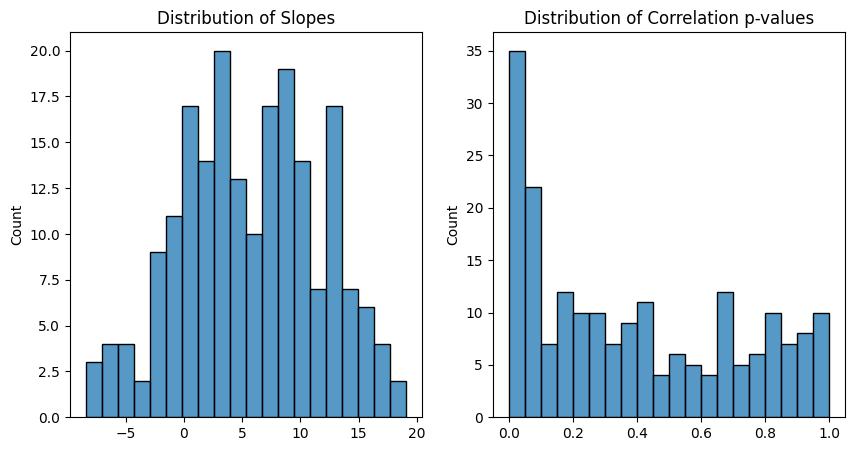

In [26]:
# Exercise 3A

# visual overview of slops and pearson correlations
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.histplot(reactivation_slopes,bins=20)
plt.title("Distribution of Slopes")
plt.subplot(1,2,2)
sns.histplot(reactivation_pvalues,bins=20)
plt.title("Distribution of Correlation p-values")


def evaluate_detection(reactivation_slopes, reactivation_pvalues, slope_thresh = 'std', p_thresh = 0.05):

    # set slope threshold
    if slope_thresh == 'std':
        slope_thresh_val = np.std(reactivation_slopes)
    else:
        slope_thresh_val = slope_thresh

    significant = (reactivation_pvalues < p_thresh)
    strong_slope = (np.abs(reactivation_slopes) > slope_thresh_val)

    false_positives = np.sum(significant & ~strong_slope)
    false_negatives = np.sum(~significant & strong_slope)

    return {
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'total_significant': np.sum(significant),
        'total_strong_slope': np.sum(strong_slope)
    }

print("False Positives:",false_positives)
print("False Negatives:",false_negatives)

**Report**

In order to identify false positives, i.e. reactivation is detected even though it is not present, and false negatives, i.e. reactivation is not detected even though it exists, we can get a first estimation by examining the distribution of slope values and correlation p-values. 

The distribution of p-values shows a sharp peak near 0, while the remaining values are evenly distributed. The peak indicates that many of the observations are significant, so we have reason to believe that reactivation is present and that we do not have too many false positives. 

The distribution of the slope values is not centred around 0, with most slopes being positive. This suggests that reactivation progresses, i.e. we have sequences in which the decoded location increases in time. 

To obtain numerical counts, I set the p-value threshold to p < 0.05 and a slope threshold to 1 standard deviation.

False positives were defined as observations with p < 0.05 but slope around 0.
False negatives were defined as observations with slope far from 0, but p >= 0.05.

Results can be seen above. Changing the value of the slope threshold significantly affects the number of false negatives. There appear to be no false positives. 

False Positives with increasing noise levels: [2, 1, 1, 0, 0]
False Negatives with increasing noise levels: [12, 17, 16, 18, 18]


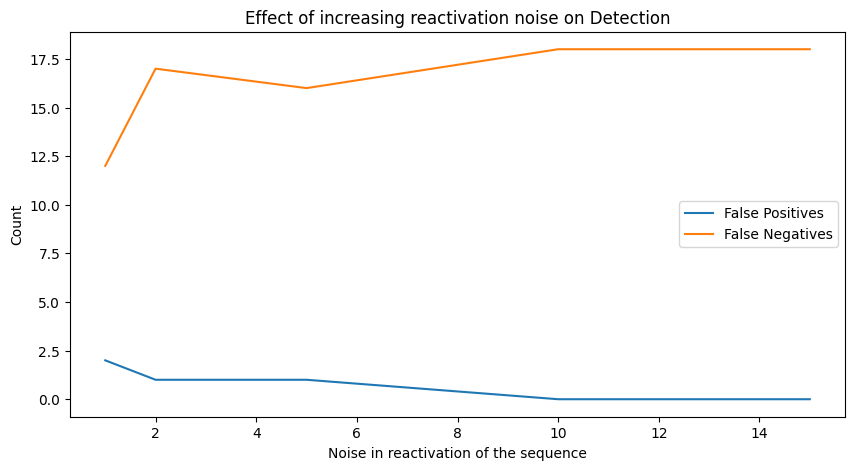

In [36]:
# Exercise 3B: changing reactivation noise

n_events = 50 # number of reactivation events
event_duration = 100 # in bins
sampling_rate = 100 # sampling rate 
t_react = np.arange(0,100)
noise_firing_rate = 0.1 # the baseline noise firing rate
noise_t_react=5; # Noise in the timing of the spikes

x_noise_levels = (1, 2, 5, 10, 15)
x_false_positives = []
x_false_negatives = []

for level in x_noise_levels:
    reactivation_events = np.zeros((n_events,event_duration))
    spikes_react = np.zeros((n_events,n_cells,event_duration))

    for event in range(n_events):
        if(event<=n_events//2):
        #Generate "real" sequences for the first half of events
            x_start = np.random.uniform(0,track_length) # Starting point
            x_end = np.random.uniform(0,track_length) # Ending point
            x_react = np.linspace(x_start,x_end,event_duration) \
                +np.random.normal(0,level,size=event_duration)

        else:
            #Pick locations randomly for the second half 
            x_react = np.random.uniform(0,track_length,size=event_duration);

        x_react[x_react<0]=0;
        x_react[x_react>track_length]=track_length

        #store reactivation sequence
        reactivation_events[event,:] = x_react


        # Generate spikes according to the location being reactivated in this event

        for i in range(n_cells):
            binned_x = np.digitize(x_react,bins=np.linspace(0,track_length,firing_rate_maps.shape[-1]))-1
            inst_rate = firing_rate_maps[i,binned_x] + np.random.normal(0,noise_firing_rate,size=len(binned_x))
            inst_rate[inst_rate<0] = 0
            spikes_loc = np.where(np.random.poisson(inst_rate/sampling_rate)>0)
            spikes_loc = spikes_loc + np.round(np.random.normal(0,noise_t_react,size=len(spikes_loc)))
            spikes_loc = spikes_loc[np.logical_and(spikes_loc>0,spikes_loc<event_duration)]
            spikes_react[event,i,spikes_loc.astype(int)] = 1     


    # decoding        

    time_window = 10 # number of bins to aggregate during decoding

    reactivation_slope = np.zeros(n_events)

    for event in range(n_events):

        event_spikes = spikes_react[event]
        # First we bin the events in windows of 10 bins
        spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//time_window))
        # We generate a new spike matrix with the re-sized window
        for t_r in range(1,event_spikes.shape[1]//time_window):
            spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*time_window :(t_r)*time_window],axis=1)


    t_resize = 10 # We use spikes from multiple time windows for the decoding

    reactivation_slopes = np.zeros(n_events)
    reactivation_pvalues = np.zeros(n_events)

    for event in range(n_events):

        event_spikes = spikes_react[event]
        spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//t_resize))

        # We generate a new spike matrix with the re-sized window
        for t_r in range(1,event_spikes.shape[1]//t_resize):
            spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*t_resize :(t_r)*t_resize],axis=1)


        # We then perform decoding on the aggregated spikes
        x_decoded = np.zeros(spikes_sampled.shape[1])

        for t_bin in range(spikes_sampled.shape[1]):

            if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes

                posterior = np.empty(firing_rate_maps.shape[-1])
                for i in range(len(posterior)):
                    posterior[i] = sum(poisson.logpmf(spikes_sampled[:,t_bin],firing_rate_maps[:,i]*t_resize/fps)+pow(1,-15))

                x_decoded[t_bin] = space_bins[np.argmax(posterior)]

            else:
                x_decoded[t_bin] = np.nan   

            # We fit a line to the decoded positions, and save the slope
            slope,_ = np.polyfit(np.arange(len(x_decoded)),x_decoded,deg=1)
            reactivation_slopes[event] = slope
            # And calculate the pvalue of the pearson correlation
            corr = pearsonr(np.arange(len(x_decoded)),x_decoded)
            reactivation_pvalues[event] = corr[1]
            
    # evaluate
    results = evaluate_detection(reactivation_slopes, reactivation_pvalues, slope_thresh = 'std', p_thresh = 0.05)
    x_false_positives.append(results['false_positives'])
    x_false_negatives.append(results['false_negatives'])

print("False Positives with increasing noise levels:",x_false_positives)
print("False Negatives with increasing noise levels:",x_false_negatives)

plt.figure()
plt.plot(x_noise_levels, x_false_positives, label = "False Positives")
plt.plot(x_noise_levels, x_false_negatives, label = "False Negatives")
plt.xlabel("Noise in reactivation of the sequence")
plt.ylabel("Count")
plt.title("Effect of increasing reactivation noise on Detection")
plt.legend()

**Report**

Increasing the sequence reactivation noise results in:
-  a slight decrease in false positives (but mostly stable): random events don’t increase too much from structured noise
-  an increase in false negatives: real sequences become noisier and harder to detect



False Positives with increasing noise levels: [2, 1, 0, 0, 0]
False Negatives with increasing noise levels: [15, 9, 17, 21, 18]


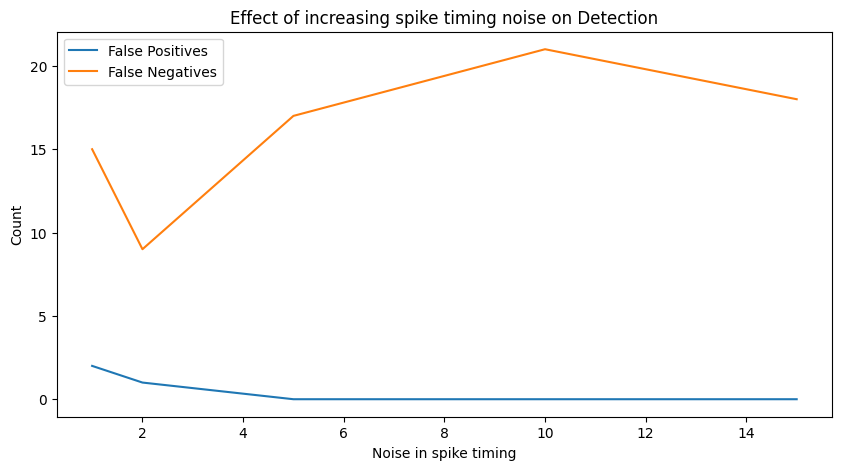

In [37]:
# Exercise 3B: changing spike timing noise

n_events = 50 # number of reactivation events
event_duration = 100 # in bins
sampling_rate = 100 # sampling rate 
t_react = np.arange(0,100)
noise_firing_rate = 0.1 # the baseline noise firing rate
noise_x_react=5; # Noise in the reactivation of the sequence

t_noise_levels = (1, 2, 5, 10, 15)
t_false_positives = []
t_false_negatives = []

for level in t_noise_levels:
    reactivation_events = np.zeros((n_events,event_duration))
    spikes_react = np.zeros((n_events,n_cells,event_duration))

    for event in range(n_events):
        if(event<=n_events//2):
        #Generate "real" sequences for the first half of events
            x_start = np.random.uniform(0,track_length) # Starting point
            x_end = np.random.uniform(0,track_length) # Ending point
            x_react = np.linspace(x_start,x_end,event_duration) \
                +np.random.normal(0,noise_x_react,size=event_duration)

        else:
            #Pick locations randomly for the second half 
            x_react = np.random.uniform(0,track_length,size=event_duration);

        x_react[x_react<0]=0;
        x_react[x_react>track_length]=track_length

        #store reactivation sequence
        reactivation_events[event,:] = x_react


        # Generate spikes according to the location being reactivated in this event

        for i in range(n_cells):
            binned_x = np.digitize(x_react,bins=np.linspace(0,track_length,firing_rate_maps.shape[-1]))-1
            inst_rate = firing_rate_maps[i,binned_x] + np.random.normal(0,noise_firing_rate,size=len(binned_x))
            inst_rate[inst_rate<0] = 0
            spikes_loc = np.where(np.random.poisson(inst_rate/sampling_rate)>0)
            spikes_loc = spikes_loc + np.round(np.random.normal(0,level,size=len(spikes_loc)))
            spikes_loc = spikes_loc[np.logical_and(spikes_loc>0,spikes_loc<event_duration)]
            spikes_react[event,i,spikes_loc.astype(int)] = 1     


    # decoding        

    time_window = 10 # number of bins to aggregate during decoding

    reactivation_slope = np.zeros(n_events)

    for event in range(n_events):

        event_spikes = spikes_react[event]
        # First we bin the events in windows of 10 bins
        spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//time_window))
        # We generate a new spike matrix with the re-sized window
        for t_r in range(1,event_spikes.shape[1]//time_window):
            spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*time_window :(t_r)*time_window],axis=1)


    t_resize = 10 # We use spikes from multiple time windows for the decoding

    reactivation_slopes = np.zeros(n_events)
    reactivation_pvalues = np.zeros(n_events)

    for event in range(n_events):

        event_spikes = spikes_react[event]
        spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//t_resize))

        # We generate a new spike matrix with the re-sized window
        for t_r in range(1,event_spikes.shape[1]//t_resize):
            spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*t_resize :(t_r)*t_resize],axis=1)


        # We then perform decoding on the aggregated spikes
        x_decoded = np.zeros(spikes_sampled.shape[1])

        for t_bin in range(spikes_sampled.shape[1]):

            if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes

                posterior = np.empty(firing_rate_maps.shape[-1])
                for i in range(len(posterior)):
                    posterior[i] = sum(poisson.logpmf(spikes_sampled[:,t_bin],firing_rate_maps[:,i]*t_resize/fps)+pow(1,-15))

                x_decoded[t_bin] = space_bins[np.argmax(posterior)]

            else:
                x_decoded[t_bin] = np.nan   

            # We fit a line to the decoded positions, and save the slope
            slope,_ = np.polyfit(np.arange(len(x_decoded)),x_decoded,deg=1)
            reactivation_slopes[event] = slope
            # And calculate the pvalue of the pearson correlation
            corr = pearsonr(np.arange(len(x_decoded)),x_decoded)
            reactivation_pvalues[event] = corr[1]
            
    # evaluate
    results = evaluate_detection(reactivation_slopes, reactivation_pvalues, slope_thresh = 'std', p_thresh = 0.05)
    t_false_positives.append(results['false_positives'])
    t_false_negatives.append(results['false_negatives'])

print("False Positives with increasing noise levels:",t_false_positives)
print("False Negatives with increasing noise levels:",t_false_negatives)

plt.figure()
plt.plot(t_noise_levels, t_false_positives, label = "False Positives")
plt.plot(t_noise_levels, t_false_negatives, label = "False Negatives")
plt.xlabel("Noise in spike timing")
plt.ylabel("Count")
plt.title("Effect of increasing spike timing noise on Detection")
plt.legend()

**Report**

Increasing the spike timing noise results in:
- Increased false negatives: disruptions in timing weakens correlations and reduces the apparent slope
- False positive slightly decrease, but are mostly stable

**Exercise 3C**

The sequence detection method is suited for identifying smooth, monotonic reactivations, for example, forward and reverse replay of spatial trajectories. However, it can miss more complex or noisy forms of sequential activity, including non-linear, fragmented, or non-monotonic sequences. To detect activity like that, more flexible approaches like Hidden Markov Models or dynamic time warping could improve sensitivity, while also being  robust to timing variability and noise.
